In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
import os 
import pickle

In [2]:
from demler_tools.file_manager import path_management, io

In [3]:
path_management.initialize(project_name = 'xy_qmc')

Successfully initialized path management with following parameters:
     username:                jcurtis
     project name:            xy_qmc
     controlling machine:     workstation
     library version:         v2.3.0-beta-1-g7645a25
     auto SSH transfer:       True
     default save location:   /scratch/savefiles
     LTS mount point:         /home
     email domain:            phys.ethz.ch
     cluster OS:              Ubuntu
     cluster partition:       work
     SSH host file:           /home/jcurtis/.ssh/known_hosts
     SSH key file:            /home/jcurtis/.ssh/id_ed25519_euler
     default modules:         {'CentOS': 'gcc/8.2.0 python/3.11.2', 'Ubuntu': 'stack/2024-06 python/3.11.6'}


In [59]:
timestamp = '1753783871'

In [60]:
job_no = io.recover_job_no(timestamp = timestamp)

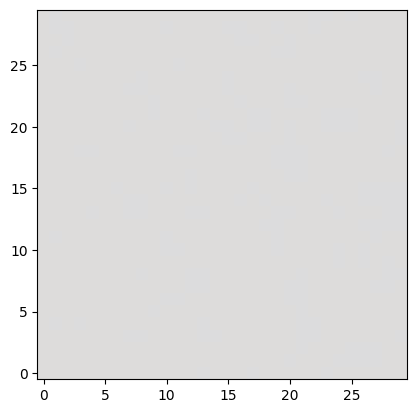

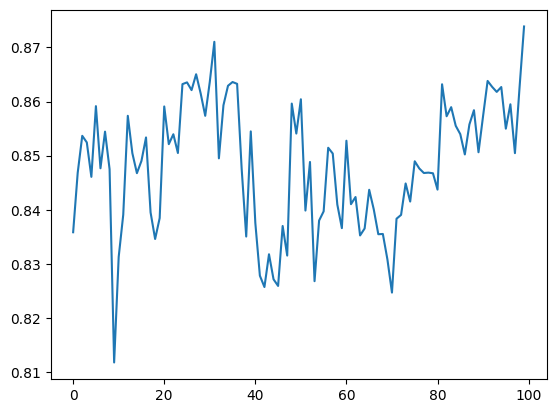

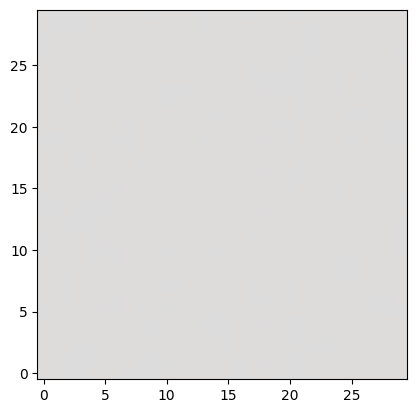

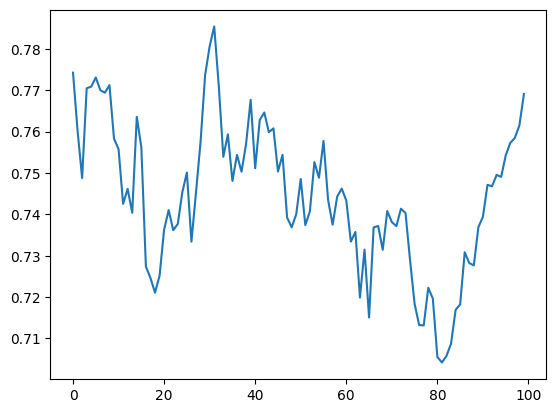

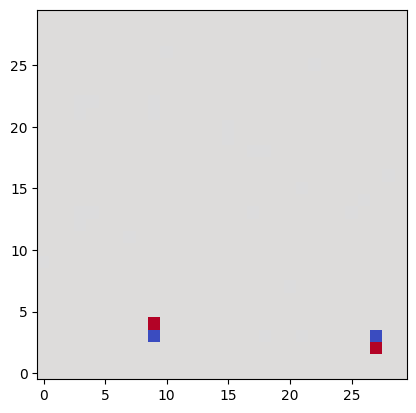

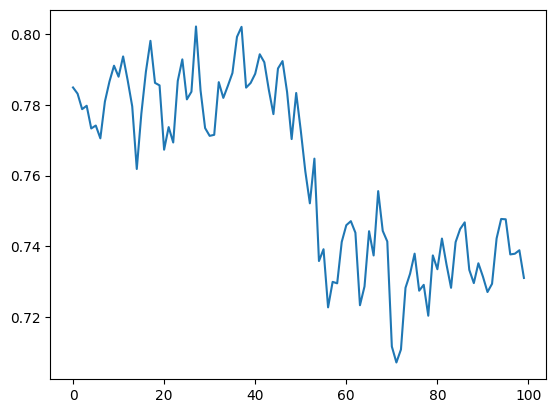

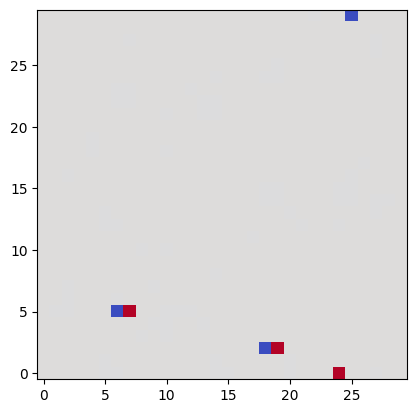

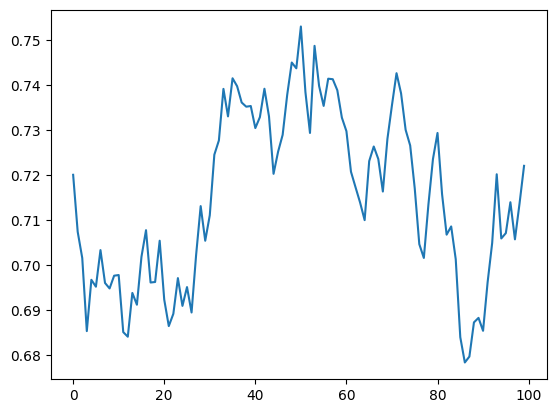

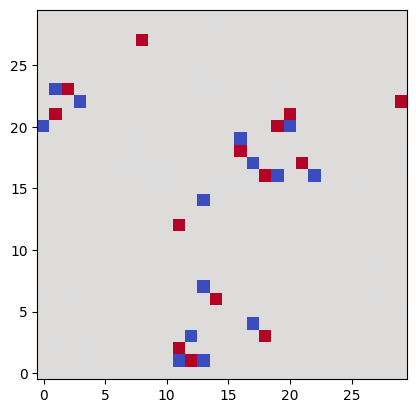

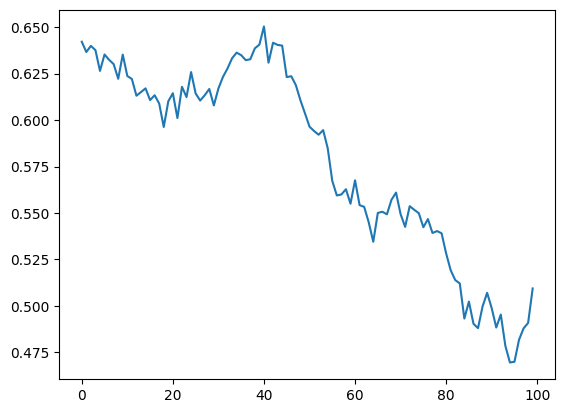

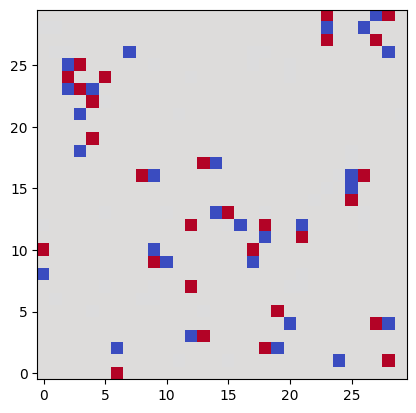

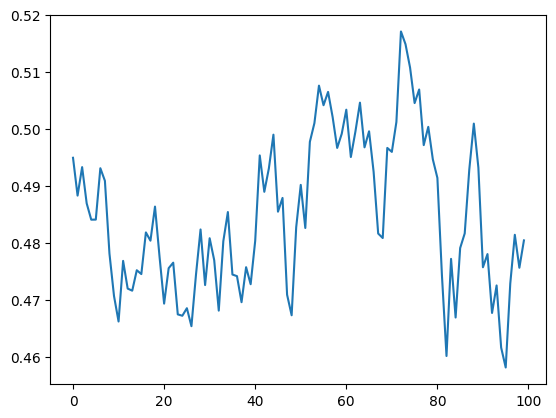

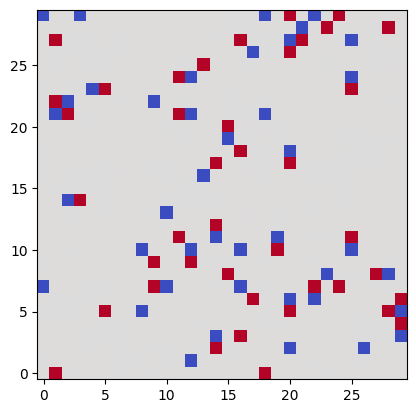

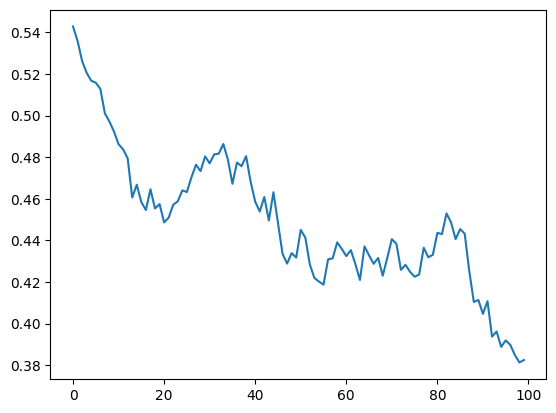

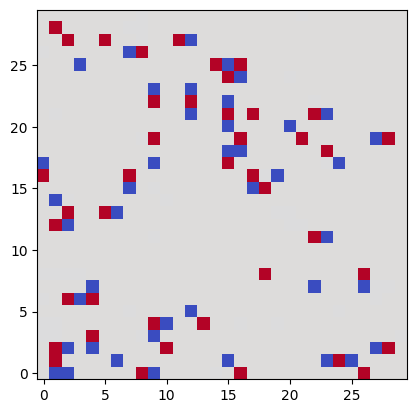

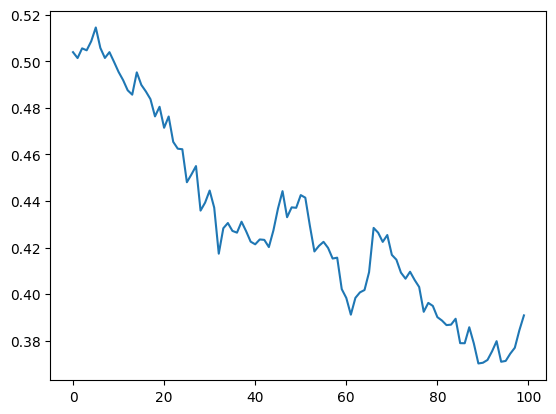

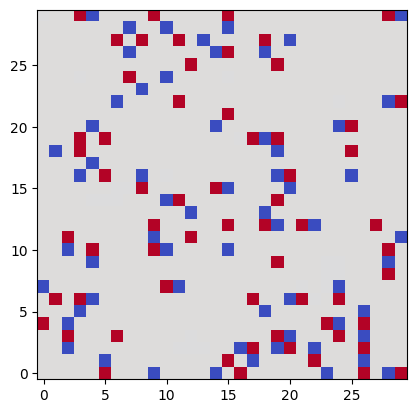

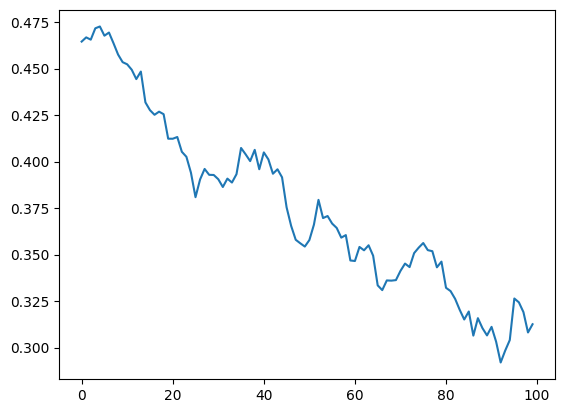

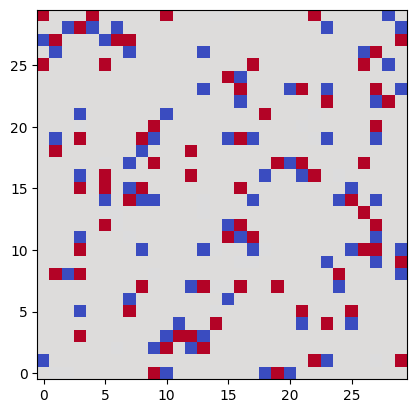

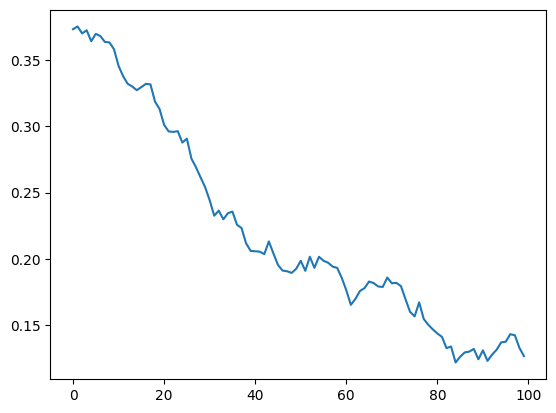

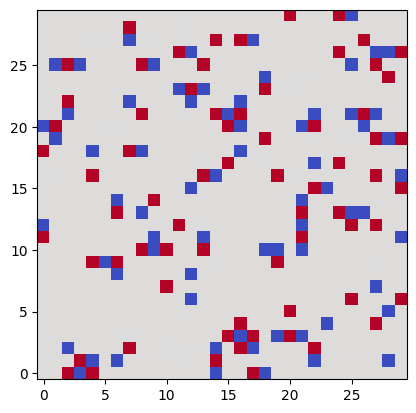

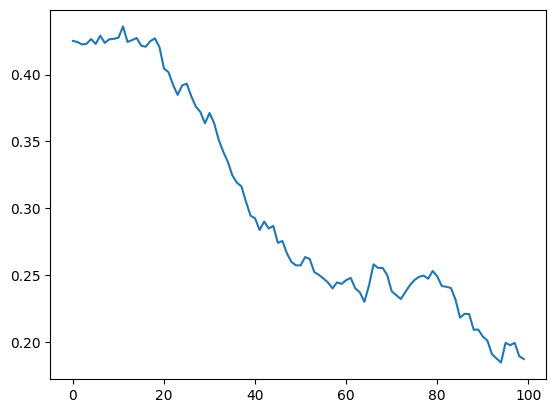

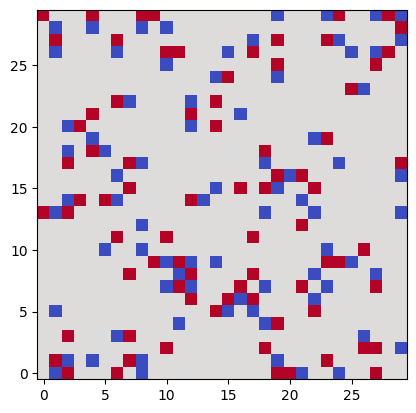

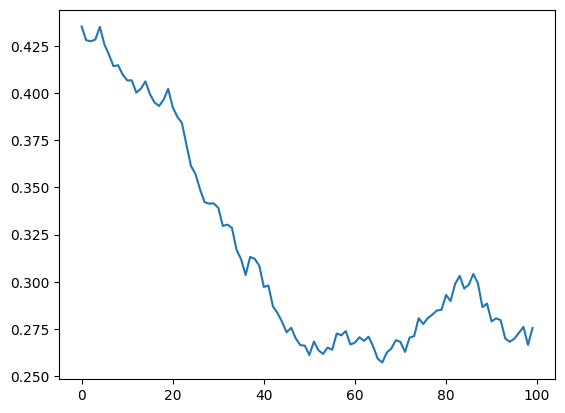

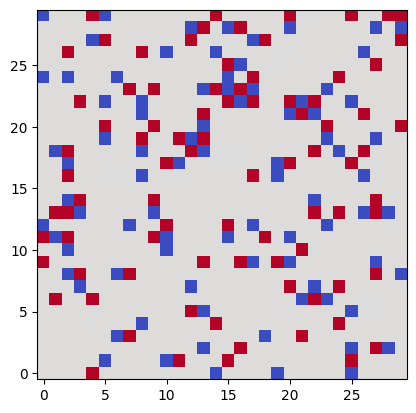

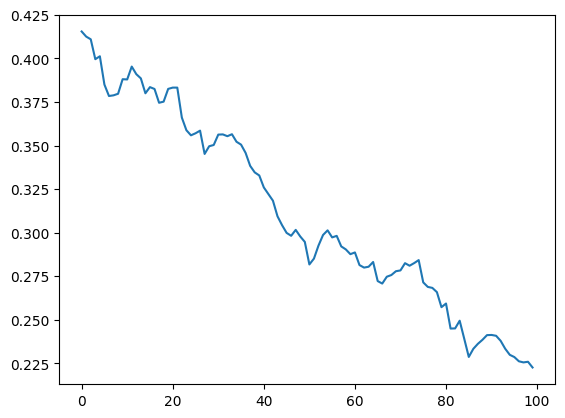

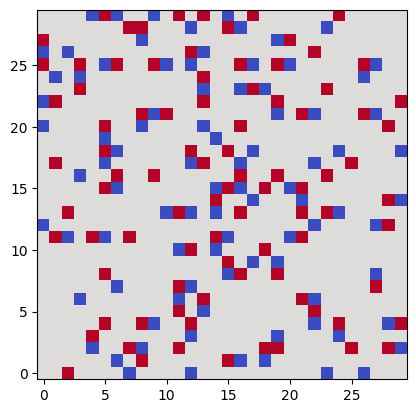

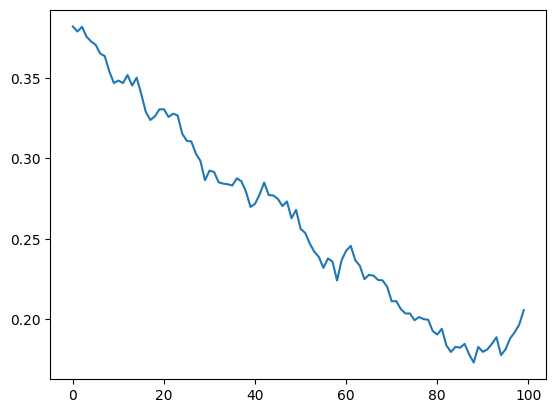

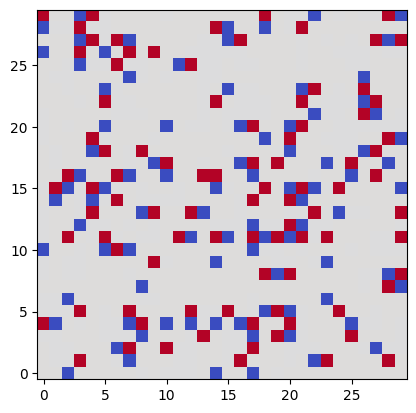

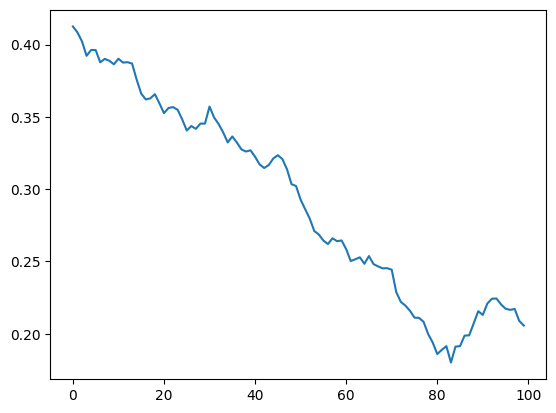

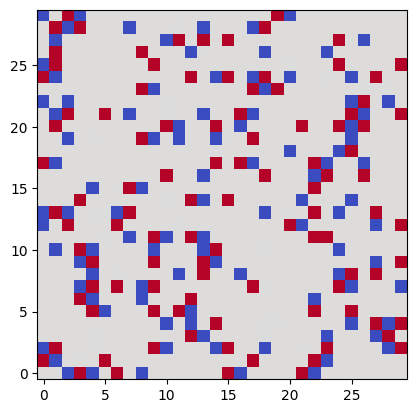

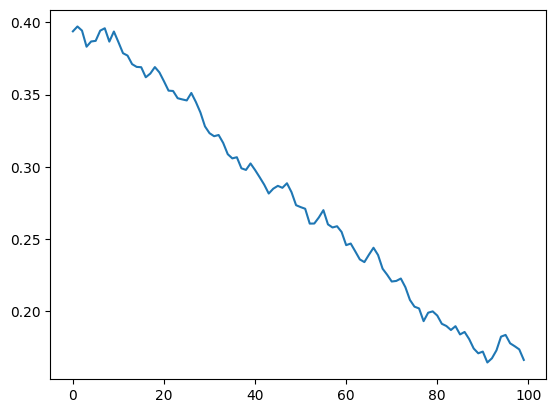

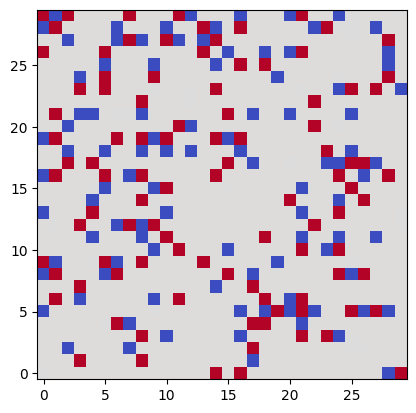

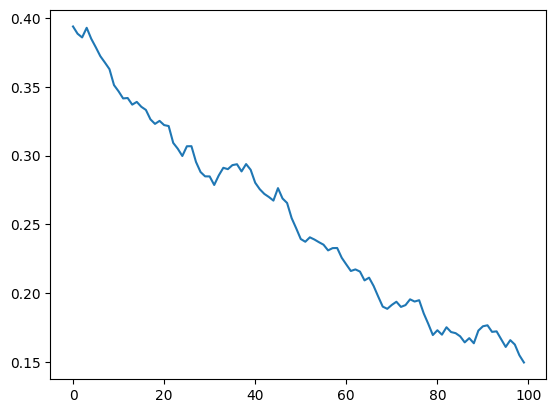

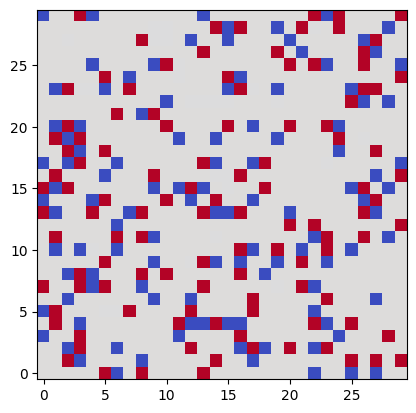

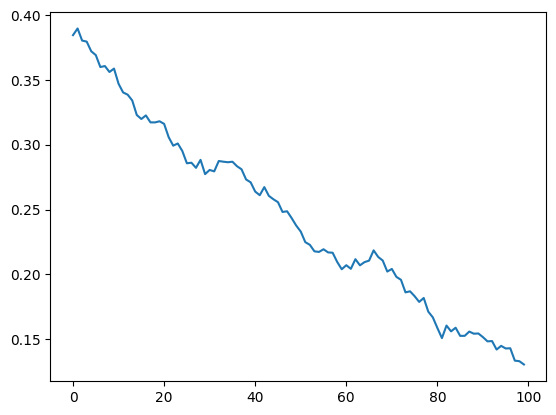

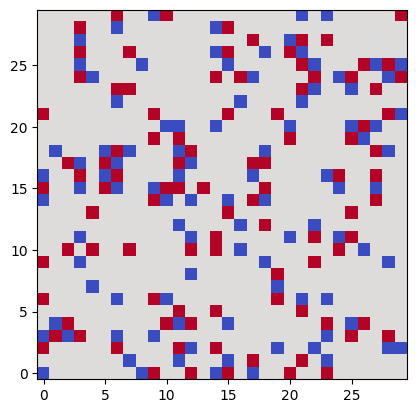

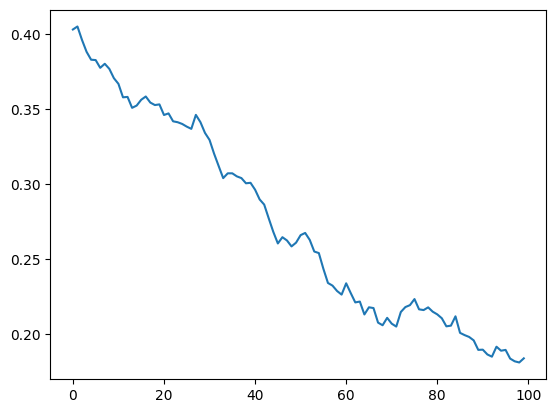

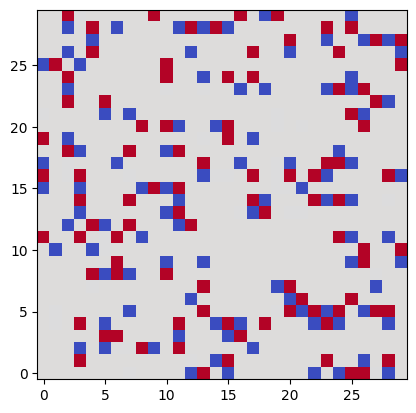

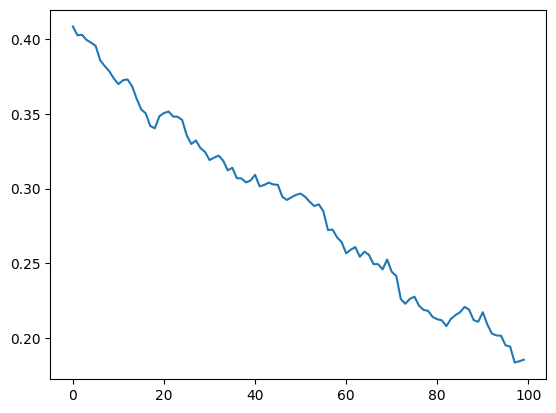

In [61]:
for job in range(job_no):
    inputs, data = io.get_results(timestamp = timestamp,run_index = job)
    actions,OPs,vorts,angles = data

    plt.imshow(np.transpose(vorts[:,:,0,-1]),origin='lower',cmap='coolwarm',norm=mclr.Normalize(-2.*np.pi,2.*np.pi) )
    plt.show()
    plt.plot(np.abs(OPs))
    plt.show()

In [8]:
timestamp = '1752245851'

In [54]:
job_no = io.recover_job_no(timestamp = timestamp)

In [55]:
shifts = np.array([0,4,8,12,16,20,30,40,50])
temps = np.zeros(job_no)
nshifts = len(shifts)
autocorrelation = np.zeros((job_no,nshifts))

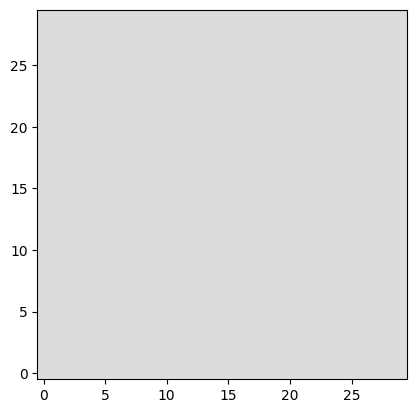

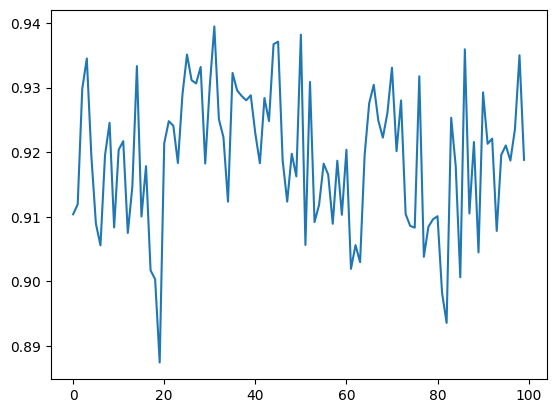

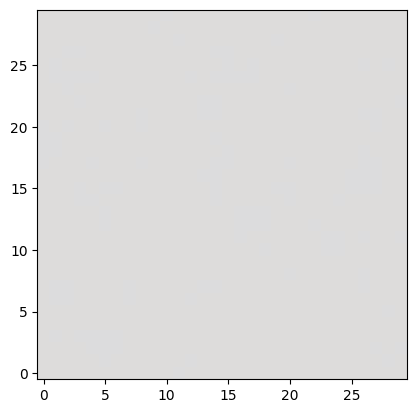

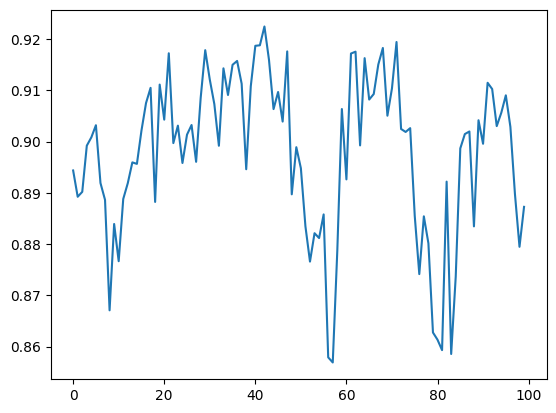

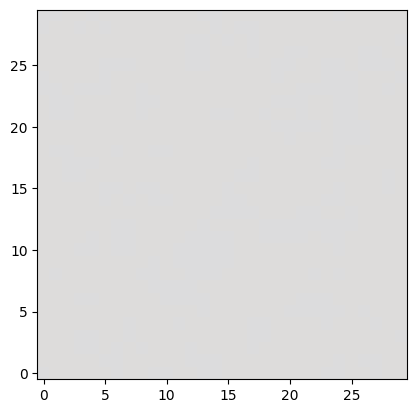

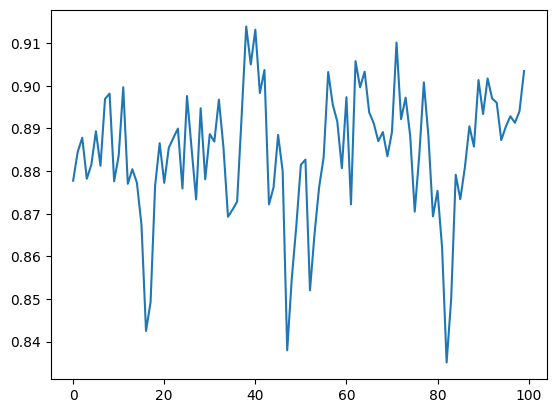

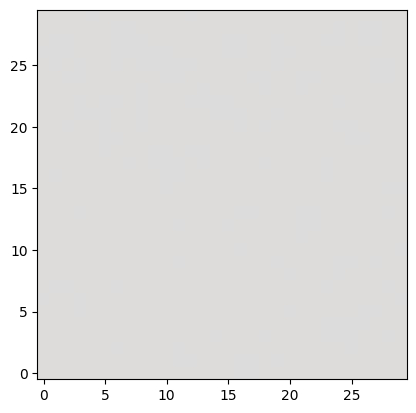

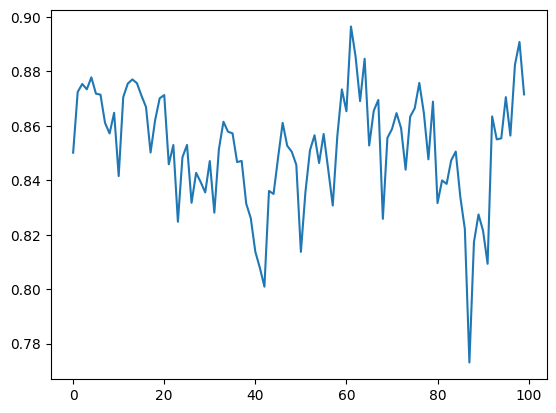

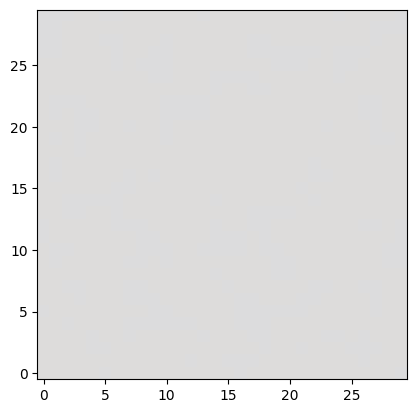

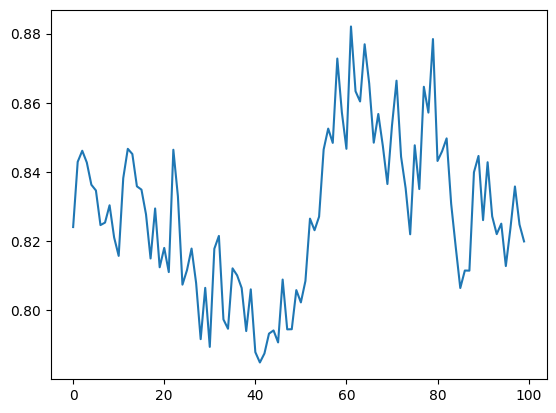

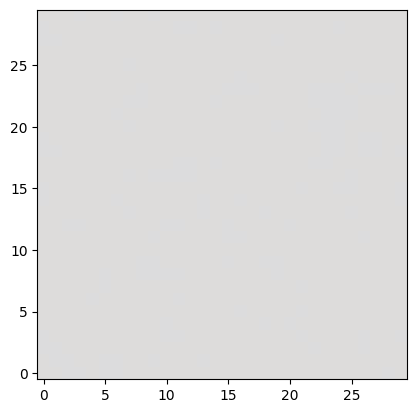

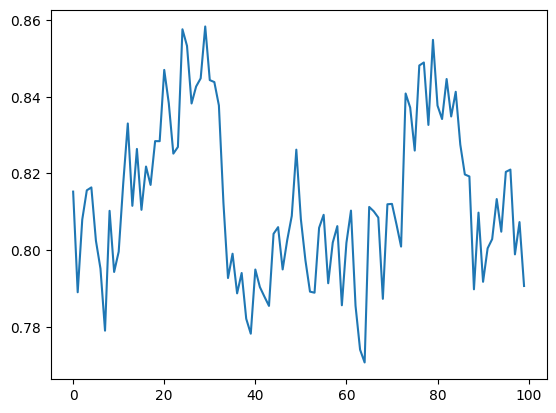

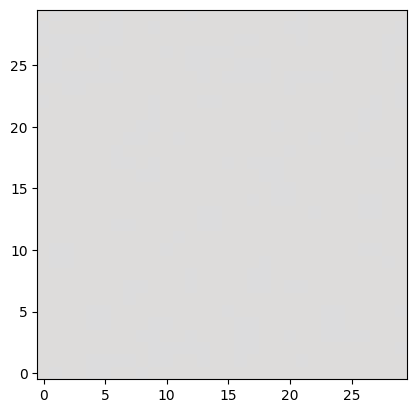

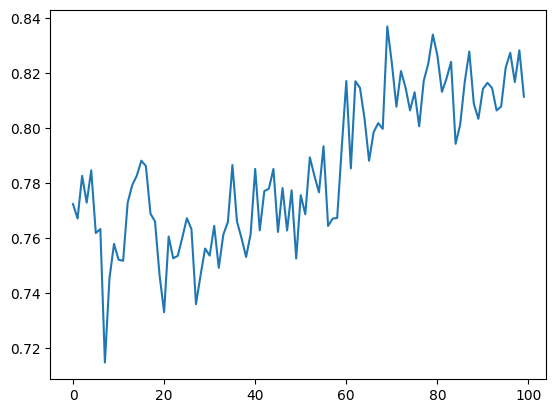

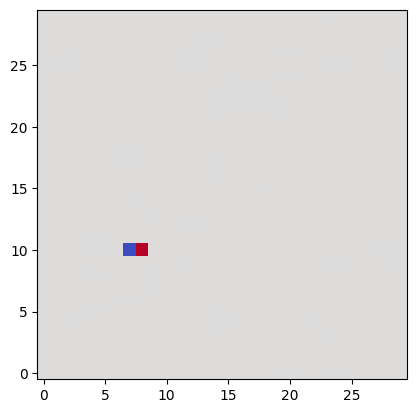

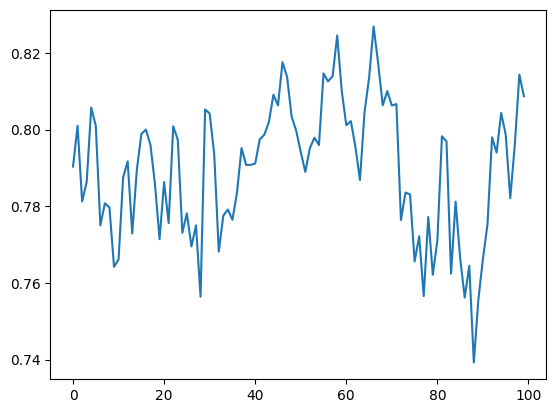

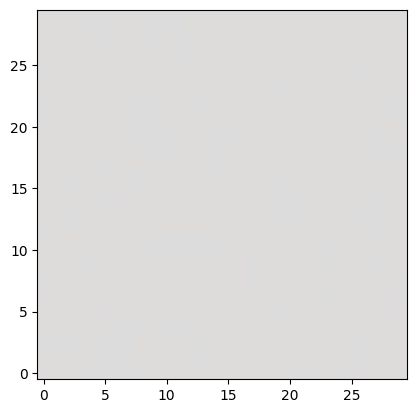

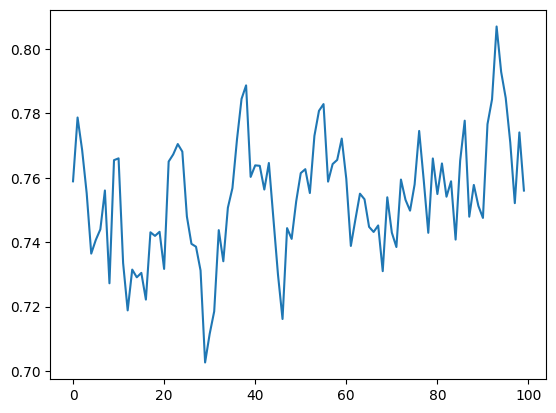

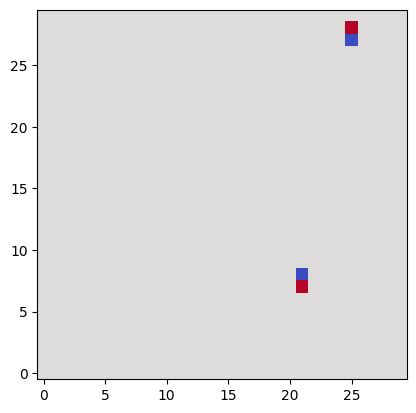

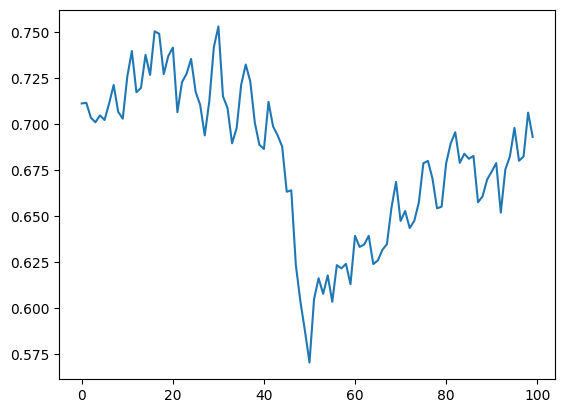

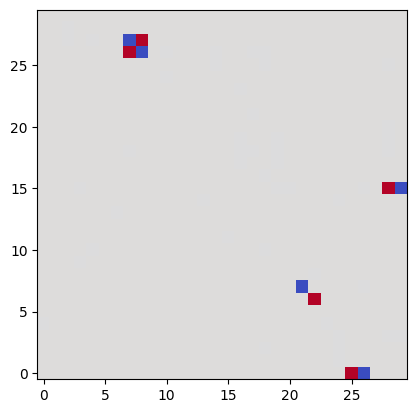

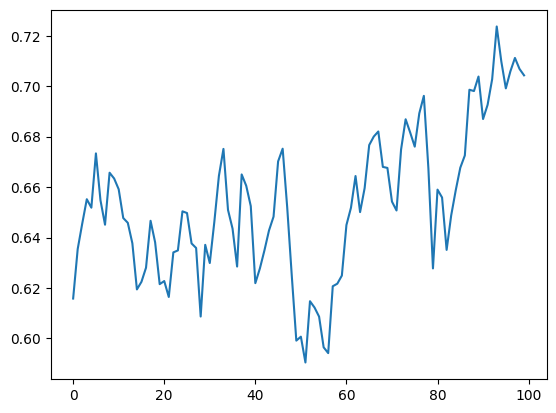

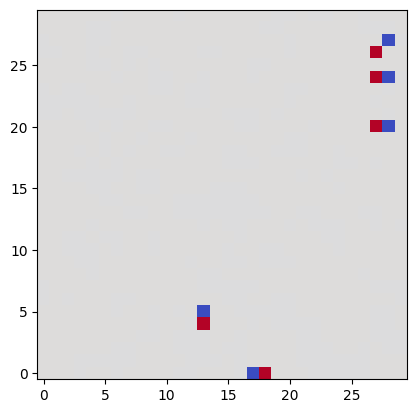

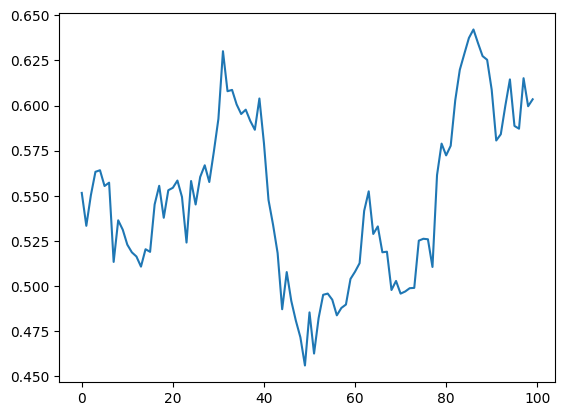

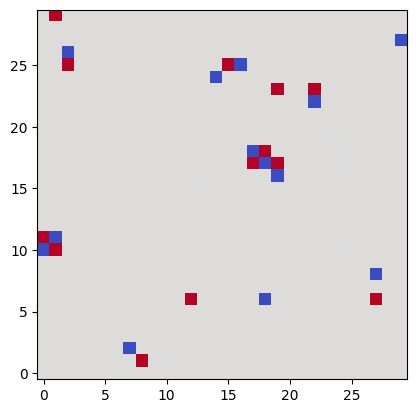

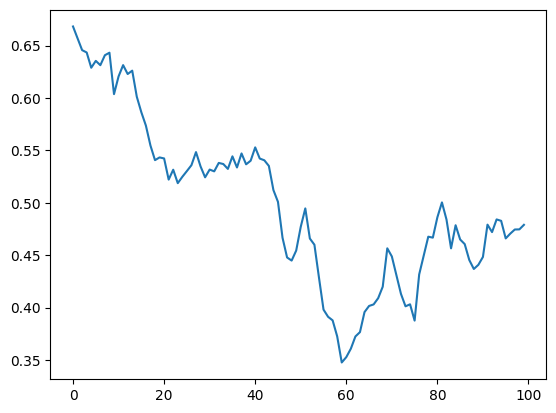

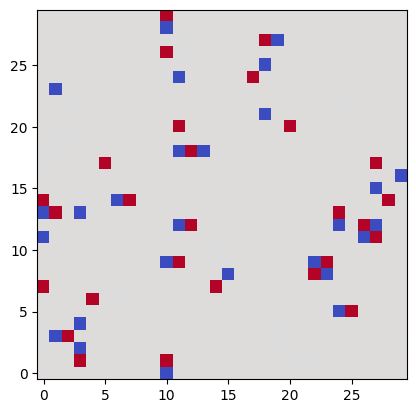

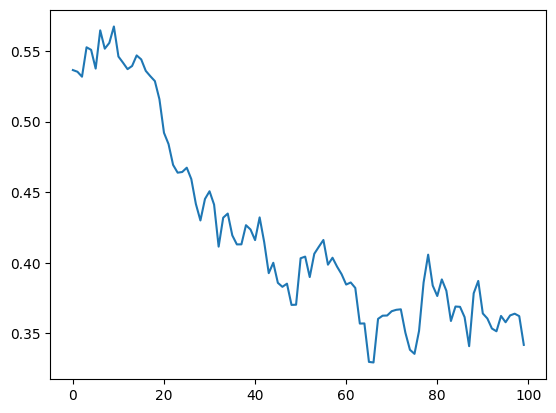

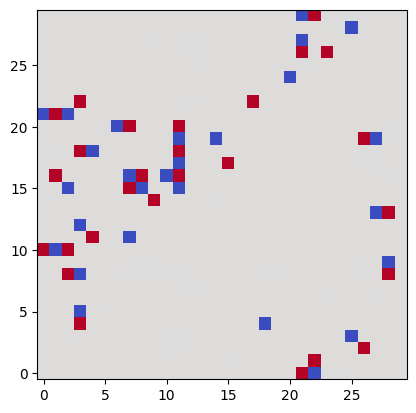

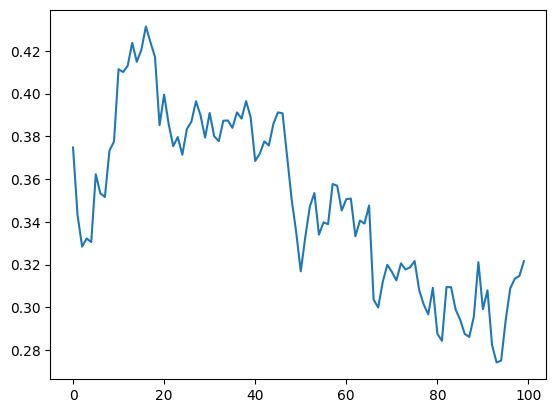

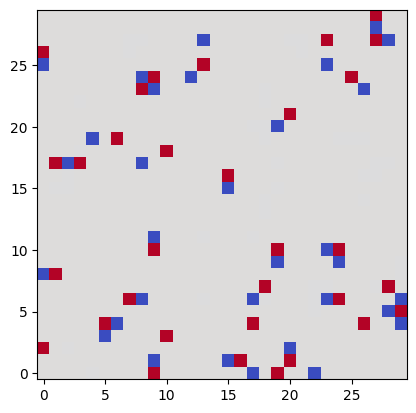

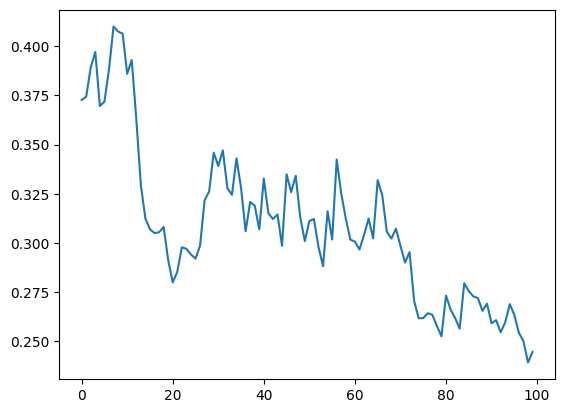

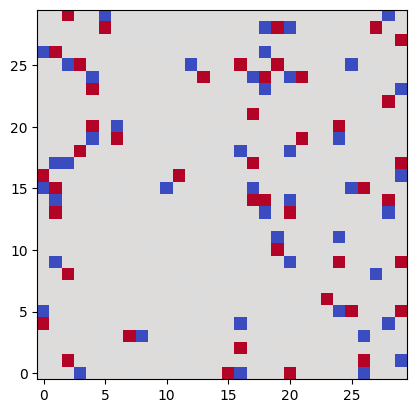

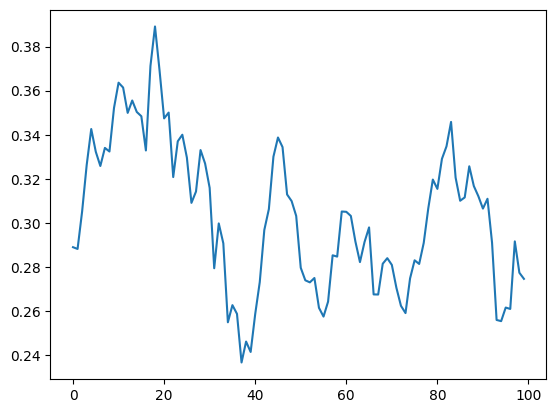

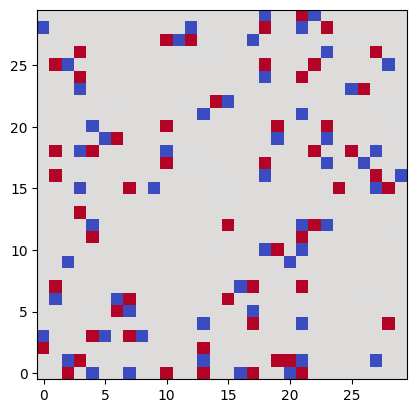

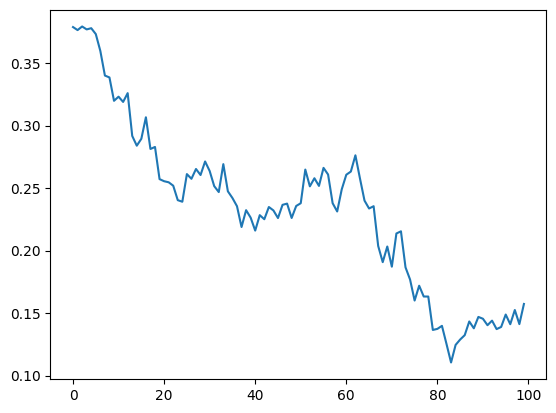

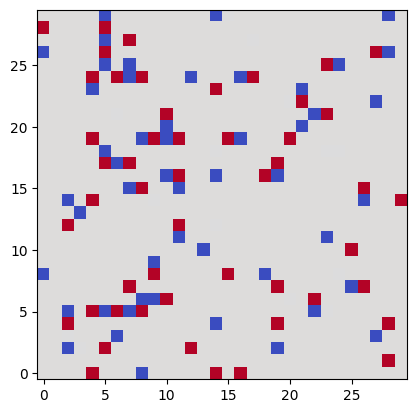

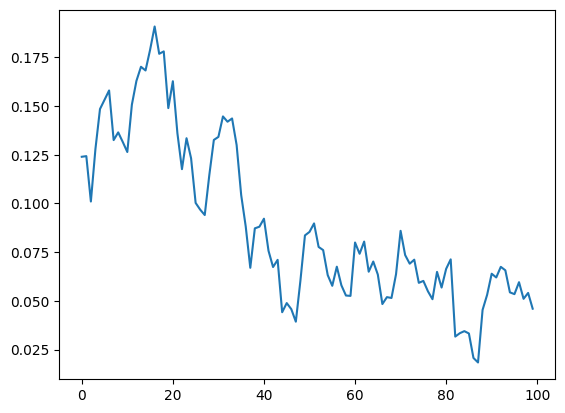

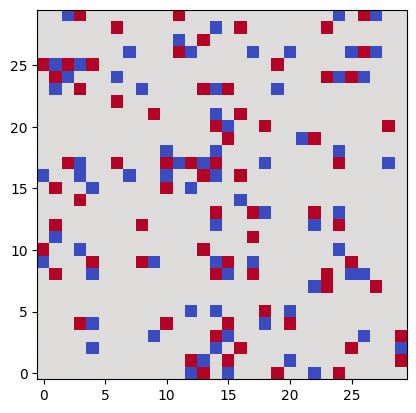

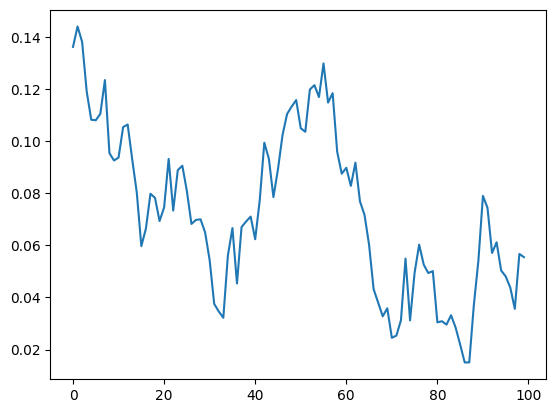

In [56]:
for job in range(job_no):
    inputs, data = io.get_results(timestamp = timestamp,run_index = job)
    temps[job] = inputs['T']
    actions,OPs,vorts,angles = data

    for i in range(nshifts):
        autocorrelation[job,i] = autocorrelator(OPs,shifts[i])

    plt.imshow(np.transpose(vorts[:,:,0,-1]),origin='lower',cmap='coolwarm',norm=mclr.Normalize(-2.*np.pi,2.*np.pi) )
    plt.show()
    plt.plot(np.abs(OPs))
    plt.show()

In [46]:
def autocorrelator(OPsamples,shift):
    ### we compute the autocorrelation function of the OP samples to see how well the overrelaxation works
    OPs_rolled = np.roll(OPsamples,shift=shift)
    return np.abs(np.mean(np.conjugate(OPs_rolled)*OPs)-np.abs(np.mean(OPs))**2)

    

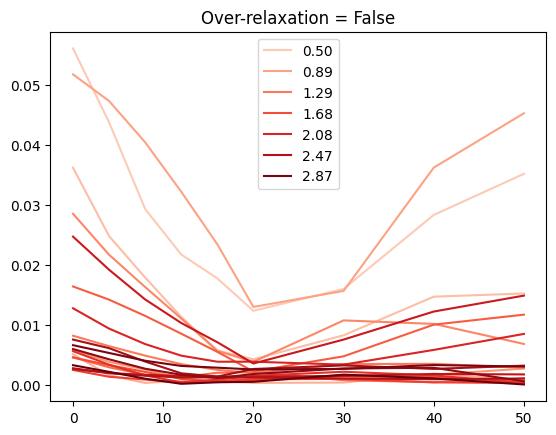

In [58]:
from matplotlib import cm
clrs = cm.Reds(np.linspace(0.2,1.,job_no))
for job in range(job_no):
    if job % 3 == 0:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job],label="{t:0.2f}".format(t=temps[job]))
    else:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job])

plt.title(r'Over-relaxation = False')
plt.legend()
plt.show()

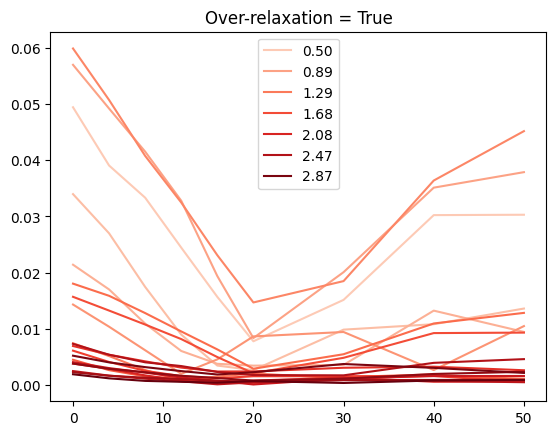

In [52]:
from matplotlib import cm
clrs = cm.Reds(np.linspace(0.2,1.,job_no))
for job in range(job_no):
    if job % 3 == 0:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job],label="{t:0.2f}".format(t=temps[job]))
    else:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job])

plt.title(r'Over-relaxation = True')
plt.legend()
plt.show()